In [233]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from multiprocessing import Pool
import healpy as hp
from astropy.coordinates import SkyCoord
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# %matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d    
import random
from sklearn.svm import SVC
from sklearn import svm

In [234]:
 # Importing the dataset containing optical clusters
df = pd.read_csv('ml_sample_real.csv', skiprows = 0, index_col=0)
# df.sort_values(by=['amf_rh'],ascending=False)
df.head()

,amf_z,amf_rh,glat,glon,amf_sn,intensity100,intensity857,intensity143,intensity353,cluster,intensity217,intensity545,intensity090_act,intensity150_act,intensity220_act
0,0.2252,200.7117,31.846666,55.602221,24.655148,-0.000048,1.978746,-0.000006,0.001062,1,0.000159,0.827244,0.0,0.0,0.0
1,0.2248,182.3373,41.429880,72.599428,44.674799,-0.000269,1.196847,-0.000215,0.000722,1,-0.000032,0.575222,0.0,0.0,0.0
2,0.3110,179.1883,65.305106,107.103759,25.696075,-0.000124,1.019871,-0.000129,0.000580,1,-0.000016,0.509922,0.0,0.0,0.0
3,0.5231,174.7108,-29.646780,100.211077,13.793623,0.000047,4.913466,0.000091,0.001929,1,0.000302,1.806498,0.0,0.0,0.0
4,0.2574,172.6889,43.387615,166.090009,20.839521,0.000029,1.074994,0.000060,0.000894,1,0.000183,0.555347,0.0,0.0,0.0


In [277]:
df[df.amf_rh>27]

,amf_z,amf_rh,glat,glon,amf_sn,intensity100,intensity857,intensity143,intensity353,cluster,intensity217,intensity545,intensity090_act,intensity150_act,intensity220_act
0,0.2252,200.7117,31.846666,55.602221,24.655148,-0.000048,1.978746,-0.000006,0.001062,1,0.000159,0.827244,0.000000,0.000000,0.000000
1,0.2248,182.3373,41.429880,72.599428,44.674799,-0.000269,1.196847,-0.000215,0.000722,1,-0.000032,0.575222,0.000000,0.000000,0.000000
2,0.3110,179.1883,65.305106,107.103759,25.696075,-0.000124,1.019871,-0.000129,0.000580,1,-0.000016,0.509922,0.000000,0.000000,0.000000
3,0.5231,174.7108,-29.646780,100.211077,13.793623,0.000047,4.913466,0.000091,0.001929,1,0.000302,1.806498,0.000000,0.000000,0.000000
4,0.2574,172.6889,43.387615,166.090009,20.839521,0.000029,1.074994,0.000060,0.000894,1,0.000183,0.555347,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10822,0.2459,27.0019,32.244550,169.210791,2.623388,0.000050,2.264996,0.000051,0.001072,1,0.000164,0.908472,0.000000,0.000000,0.000000
10823,0.3766,27.0017,68.092292,77.065256,0.178007,0.000002,0.900027,0.000023,0.000547,1,0.000078,0.467793,0.000000,0.000000,0.000000
10824,0.2658,27.0016,37.656911,160.046283,1.066812,0.000033,2.842690,0.000068,0.001100,1,0.000206,1.067997,0.000000,0.000000,0.000000
10825,0.3809,27.0009,61.007007,27.219876,2.411995,0.000045,1.988779,0.000097,0.001029,1,0.000178,0.804502,-3389.640567,-3647.087857,51160.511068


In [287]:
# Importing the dataset containing non-clusters
df2 = pd.read_csv('ml_sample_fake.csv', skiprows = 0, index_col=0)
df2.head()

,amf_z,amf_rh,glat,glon,amf_sn,intensity100,intensity857,intensity143,intensity353,cluster,intensity217,intensity545,intensity090_act,intensity150_act,intensity220_act
0,0,0,-40.545478,73.876931,0,-0.000061,0,-0.000006,0.001769,0,0,0,0,0,0
1,0,0,47.044764,122.045083,0,-0.000013,0,-0.000010,0.000449,0,0,0,0,0,0
2,0,0,-49.166830,197.088151,0,0.000165,0,0.000171,0.001142,0,0,0,0,0,0
3,0,0,-24.763621,113.881217,0,-0.000018,0,0.000014,0.001305,0,0,0,0,0,0
4,0,0,-27.146593,125.965443,0,0.000098,0,0.000110,0.001044,0,0,0,0,0,0


In [288]:
# Combine real and fake data
df3 = df[:17803].append(df2, ignore_index=True)

In [289]:
# fakeras = np.loadtxt('fakeras.csv',delimiter=', ')
# fakedecs = np.loadtxt('fakedecs.csv',delimiter=', ')

# c = SkyCoord(fakeras,fakedecs,frame='icrs',unit='deg')
# df2['glat'] = c.galactic.b.degree
# df2['glon'] = c.galactic.l.degree

# df2['intensity100'] = np.loadtxt('fakeintensity100.csv',delimiter=', ')
# df2['intensity143'] = np.loadtxt('fakeintensity143.csv',delimiter=', ')
# df2['intensity353'] = np.loadtxt('fakeintensity353.csv',delimiter=', ')
# df2.to_csv("ml_sample_fake.csv")

---

# Predicting signal in one frequency based on signal in others

#### Training

In [290]:
# From the signal in the 100Ghz image and 353Ghz image, determine the expected signal in 143Ghz
# 50 percent of the sample has richness over 27, use the richer sample for training
X = df[['intensity100', 'intensity353']][::2]
y = df['intensity143'][::2]
regr = linear_model.LinearRegression()
regr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Validation

In [291]:
# Build array of predictions for the half of the sample not used in training
X_val = df[['intensity100', 'intensity353']][1::2]

intensity143 = [regr.predict([[i,j]]) for i, j in X_val.values]

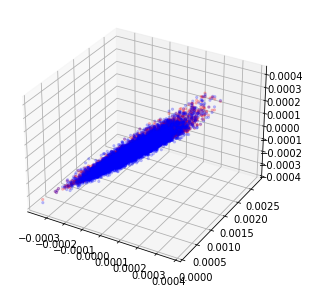

In [292]:
# Plot actual data vs predictions in three dimensions
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')

ax.scatter(df['intensity100'][1::2], df['intensity353'][1::2], df['intensity143'][1::2],s=5,c='b', alpha=0.2)
ax.scatter(df['intensity100'][1::2], df['intensity353'][1::2], intensity143, s=5, c='r', alpha=0.2)
plt.show()

---

# Classification of clusters vs non clusters

In [293]:
# Clusters
X = df[['intensity100', 'intensity143', 'intensity353']]
# Non-clusters
X_f = df2[['intensity100', 'intensity143', 'intensity353']]
# Full sample (clusters+non)
X2 = df3[['intensity100', 'intensity143', 'intensity353']]
# Classification of cluster or non
y2 = df3['cluster']

# Fit full sample with their associated classficiation
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
#clf = svm.SVR()
clf.fit(X2, y2)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [294]:
cluster = np.array([clf.predict([[i,j,k]]) for i, j, k in X.values]).flatten()

In [295]:
no_cluster = np.array([clf.predict([[i,j,k]]) for i, j, k in X_f.values]).flatten()

(array([36.88469961,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

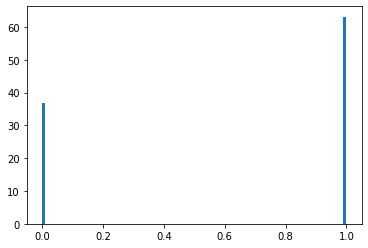

In [296]:
plt.hist(cluster,bins=100,range=(0,1),density=True)
#plt.vlines(0.5,0,2000,color='r',linestyles='dotted')
#plt.ylim(0,4)

(array([58.60809976,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

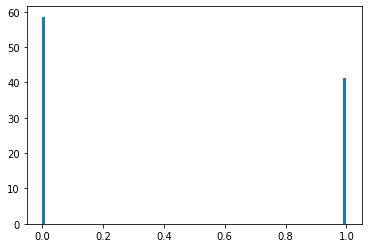

In [297]:
plt.hist(no_cluster,bins=100,range=(0,1),density=True)
#plt.vlines(0.5,0,2000,color='r',linestyles='dotted')
#plt.ylim(0,9)

---

# Identification of clusters

In [298]:
# Csv importer wrapped in a function that can be mapped for parallelization
def read_csv(filename):
    return pd.DataFrame(np.loadtxt(filename,delimiter=', ')).T

In [299]:
links100 = ['../data/results100_1.csv','../data/results100_2.csv','../data/results100_3.csv',
         '../data/results100_4.csv','../data/results100_5.csv','../data/results100_6.csv',
         '../data/results100_7.csv','../data/results100_8.csv','../data/results100_9.csv',
         '../data/results100_10.csv']
links143 = ['../data/results143_1.csv','../data/results143_2.csv','../data/results143_3.csv',
         '../data/results143_4.csv','../data/results143_5.csv','../data/results143_6.csv',
         '../data/results143_7.csv','../data/results143_8.csv','../data/results143_9.csv',
         '../data/results143_10.csv']
links353 = ['../data/results353_1.csv','../data/results353_2.csv','../data/results353_3.csv',
         '../data/results353_4.csv','../data/results353_5.csv','../data/results353_6.csv',
         '../data/results353_7.csv','../data/results353_8.csv','../data/results353_9.csv',
         '../data/results353_10.csv']

In [300]:
for links in [links100,links143,links353]:
    with Pool() as pool: 
        df_list = pool.map(read_csv, links)
        if links==links100:
            data100 = pd.concat(df_list, ignore_index=True)
        if links==links143:
            data143 = pd.concat(df_list, ignore_index=True)
        if links==links353:
            data353 = pd.concat(df_list, ignore_index=True)

In [301]:
data100 = pd.DataFrame()
data143 = pd.DataFrame()
data353 = pd.DataFrame()

for links in [links100,links143,links353]:
    if links==links100:
        for link in links:
            data100 = pd.concat([data100,pd.DataFrame(np.loadtxt(link,delimiter=', ')).T])
    if links==links143:
        for link in links:
            data143 = pd.concat([data143,pd.DataFrame(np.loadtxt(link,delimiter=', ')).T])
    if links==links353:
        for link in links:
            data353 = pd.concat([data353,pd.DataFrame(np.loadtxt(link,delimiter=', ')).T])

In [302]:
pl143 = hp.read_map('../data/HFI_SkyMap_143-field-IQU_2048_R3.00_full.fits')

/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [303]:
# Convert the RA and DEC to galactic coordinates
c = SkyCoord(data100[1],data100[2],frame='icrs',unit='deg')
data100['glat'] = c.galactic.b.degree
data100['glon'] = c.galactic.l.degree

c = SkyCoord(data143[1],data143[2],frame='icrs',unit='deg')
data143['glat'] = c.galactic.b.degree
data143['glon'] = c.galactic.l.degree

c = SkyCoord(data353[1],data353[2],frame='icrs',unit='deg')
data353['glat'] = c.galactic.b.degree
data353['glon'] = c.galactic.l.degree

In [304]:
# initialize data of lists.
data_all = {'int100':data100[0],
            'int143':data143[0],
            'int353':data353[0]}
 
intensity_all = pd.DataFrame(data_all)

In [305]:
cluster_prob = np.array([clf.predict([[i,j,k]]) for i, j, k in intensity_all[['int100', 'int143', 'int353']].values]).flatten()

In [306]:
data100['cluster']=cluster_prob

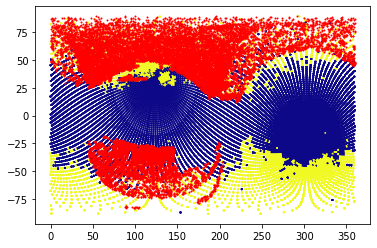

In [312]:
# hp.mollview(pl143,norm='hist',cmap='Greys',coord=['G'],title='Masked S/N map')
# hp.visufunc.projscatter(data100['glon'],data100['glat'],c=data100.cluster,cmap='plasma',lonlat=True,s=10)
plt.scatter(data100['glon'],data100['glat'],c=data100.cluster,cmap='plasma',s=1)
plt.scatter(df['glon'],df['glat'],c='r',s=1)